# Why detrend a lightcurve before doing period search?

This notebook addresses the referee's comments on our paper "TESS photometry of the nova eruption in V606 Vul: asymmetric photosphere and multiple ejections?" ([arXiv e-print](https://arxiv.org/abs/2311.04903)) submitted to ApJ. While we direct readers to the paper for the final period analysis, this notebook reproduces our main claim: the presence of a ~0.1277 day period in the nova light curve near its peak brightness, using only the standard TESS data analysis package [LightKurve](https://github.com/lightkurve/lightkurve).

The eruption of V606 Vul occurred during TESS Sector 41. We extract a lightcurve of an individual pixel overlapping with the nova image to get a realistic time sampling pattern for the simulated lightcurve. In the simulated lightcurve we assign new simulated (compeletely made up!) flux values to the time stamps extracted from the real lightcurve. In our smulation we aim to preserve the following features of the original V606 Vul lightcurve: 
1. The injected 0.123-day periodicity is numerically close to the one found in V606 Vul to accurately reflect the relation between the periodic signal and the sampling pattern.
2. The amplitude of the long-term trend is much larger than the amplitude of the periodic signal.

We apply to the simulated lightcurve the same processing steps used for the nova lightcurve extracted from a 3×3 pixel aperture in the accompanying notebook [v606_vul_lk_square_aperture.ipynb](v606_vul_lk_square_aperture.ipynb). The procedure includes:

1. Application of a Savitzky-Golay (high-pass) filter that effectively detrends (flattens) the lightcurve by removing long-term variability.
2. Sigma-clipping the lightcurve to remove outliers.
3. Constructing a Lomb-Scargle periodogram to identify periodic signals.


## Sine wave and a linear trend

In this first simulation, we demonstrate the critical importance of detrending by creating a synthetic lightcurve with the following components:

1. **Constant baseline flux**: We start with a constant flux level based on the median value from the real TESS pixel data.

2. **Injected sine wave signal**: We add a periodic sine wave with a period of 0.123 days and an amplitude of 0.5% of the constant baseline flux. This represents the underlying periodic signal we want to detect.

3. **Linear trend**: We superimpose a decreasing linear trend with an amplitude (from beginning to end of the lightcurve) matching the min-to-max range of the original TESS pixel data. This represents the slow evolution of the nova's brightness over time.

The simulation then:
- Calculates and plots the spectral window (the Fourier transform of the time sampling) to visualize potential artifacts introduced by the TESS observing cadence
- Generates periodograms for the sine-only lightcurve to establish a baseline for detection
- Generates periodograms for the trend+sine lightcurve to show how the trend masks the true signal
- Applies the `flatten()` detrending procedure to the trend+sine lightcurve
- Generates periodograms for the detrended lightcurve to demonstrate recovery of the true period

We analyze the results in both wide (0.05-3.0 days) and narrow (0.1-0.5 days) period ranges to show how different frequency search ranges affect the period detection. The simulation conclusively demonstrates that a linear trend can completely mask a periodic signal in a periodogram, and that proper detrending is essential for recovering the true periodicity.

/home/kirill/.conda/envs/lk/lib/python3.10/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /home/kirill/.lightkurve/cache. Please move all the files in the legacy directory /home/kirill/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


Searching for TESS data for V606 Vul
Found 1 TESS sectors with data
SearchResult containing 1 data products.

 #     mission     year  author exptime         target_name         distance
                                   s                                 arcsec 
--- -------------- ---- ------- ------- --------------------------- --------
  0 TESS Sector 41 2021 TESScut     475 20:21:07.7044 +29:14:09.091      0.0
Plotting the TESS image cutout...


<Figure size 800x600 with 0 Axes>

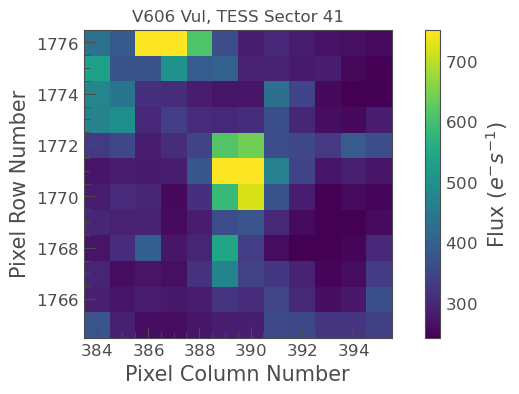

Cutout dimensions: 12 x 12 pixels
Extracting lightcurve from pixel (6, 6)


<Figure size 1200x500 with 0 Axes>

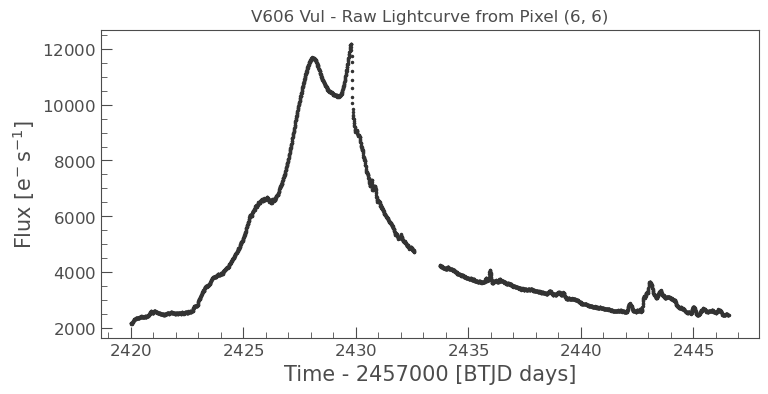

Min-to-max amplitude of real lightcurve: 10030.787109375


<Figure size 1200x500 with 0 Axes>

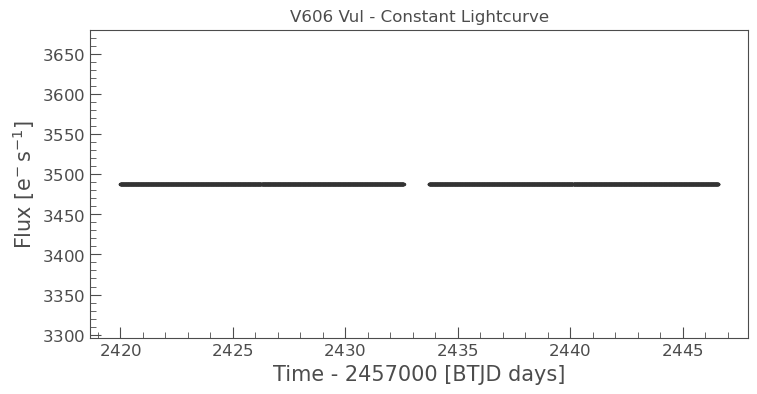

<Figure size 1200x500 with 0 Axes>

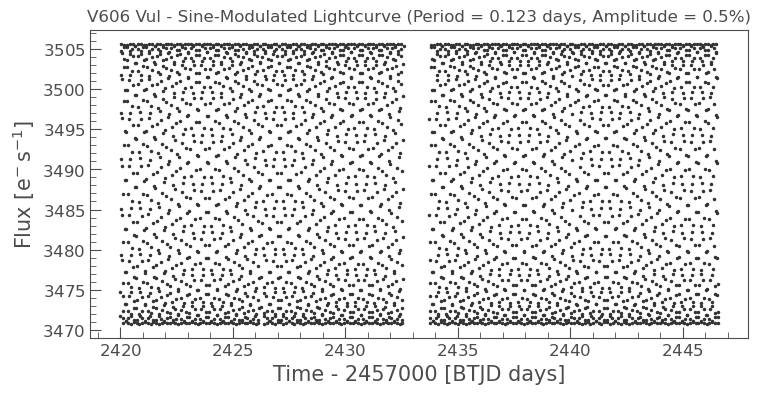

Computing spectral window using DFT method...


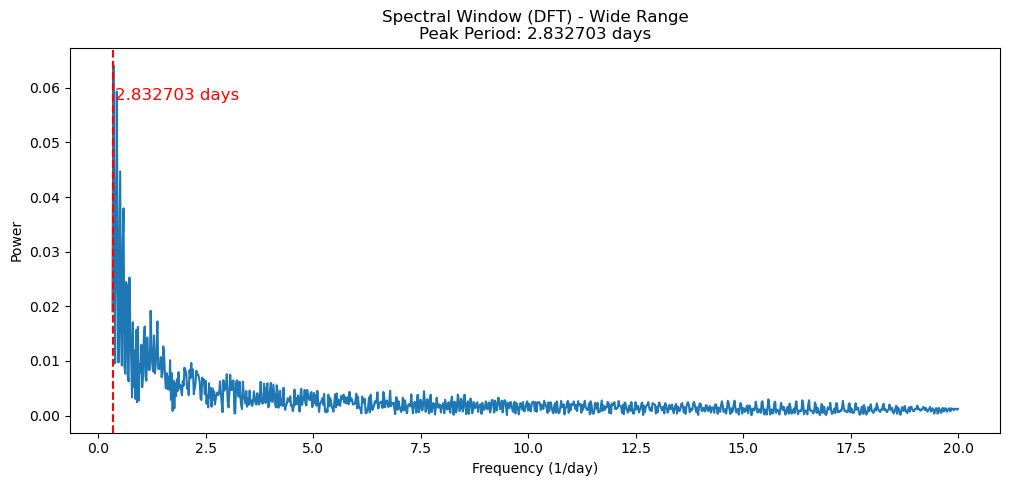

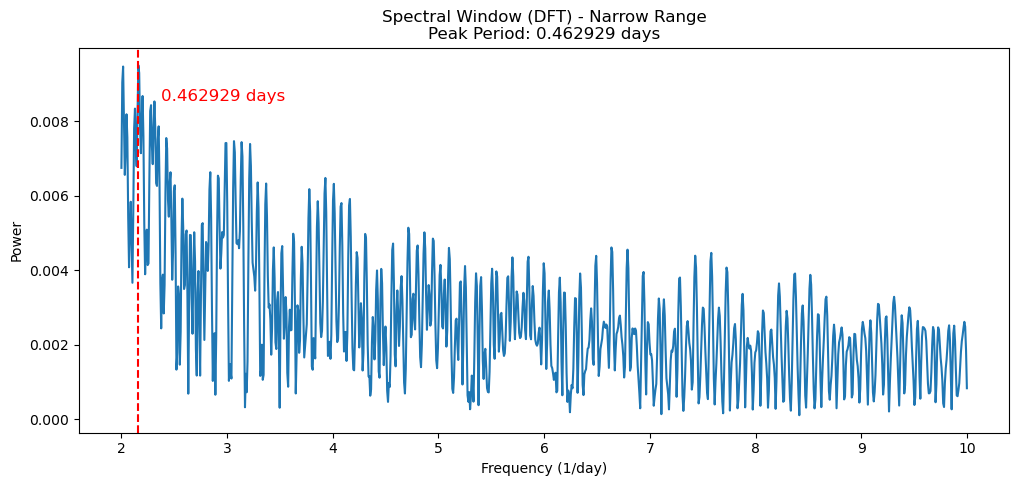

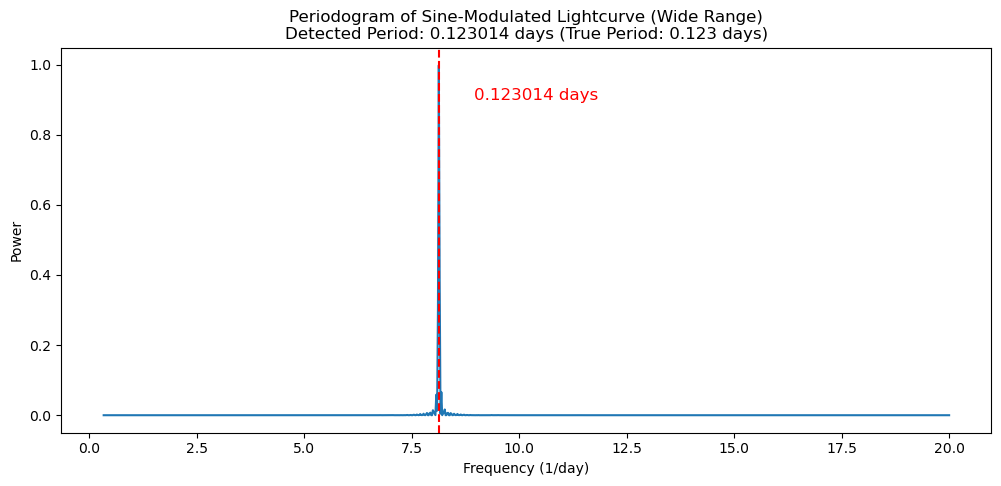

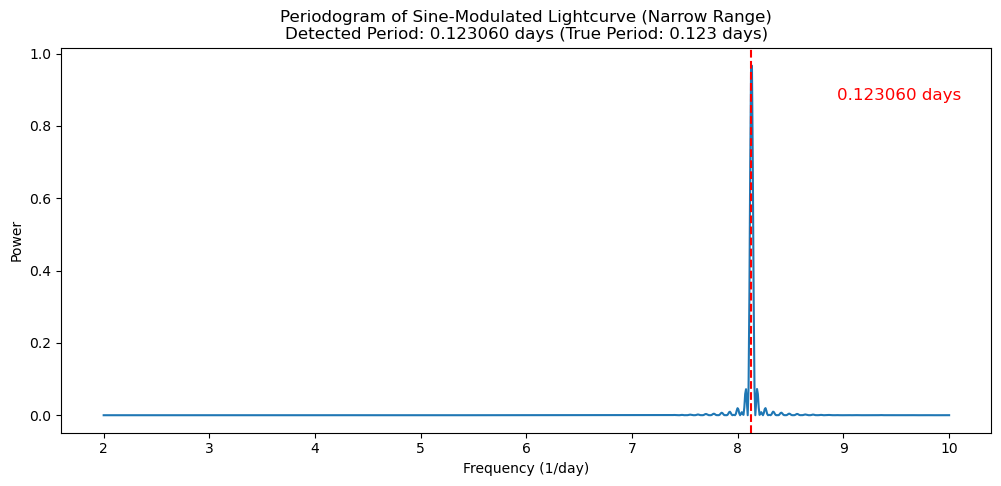

<Figure size 1200x500 with 0 Axes>

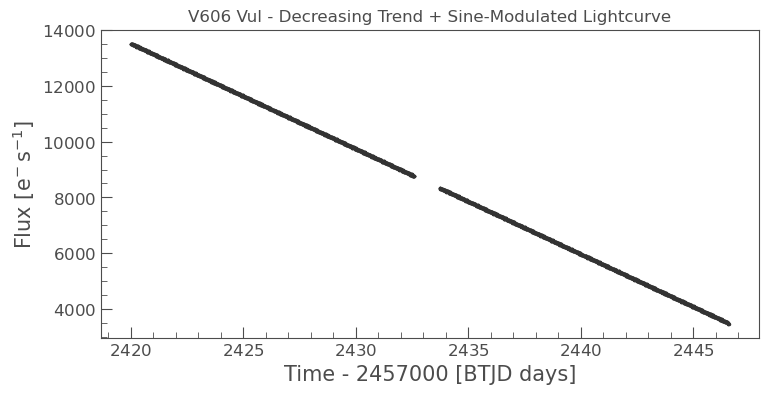

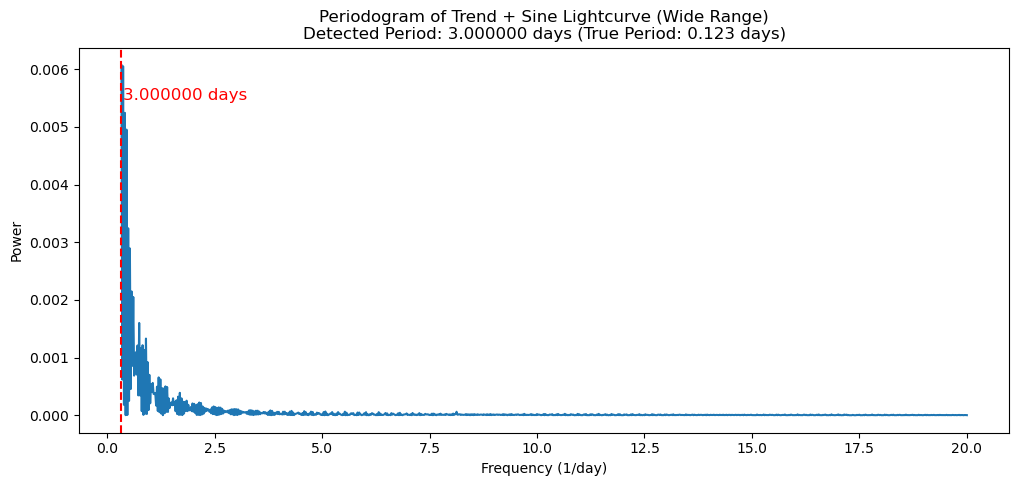

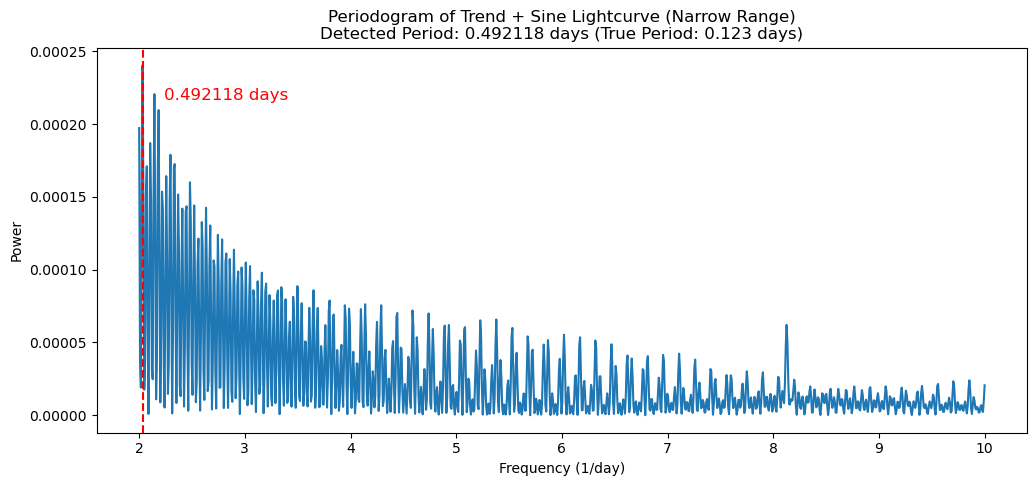

<Figure size 1200x500 with 0 Axes>

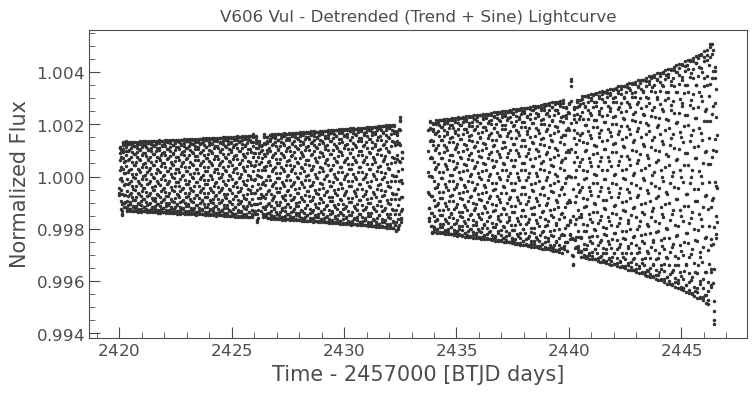

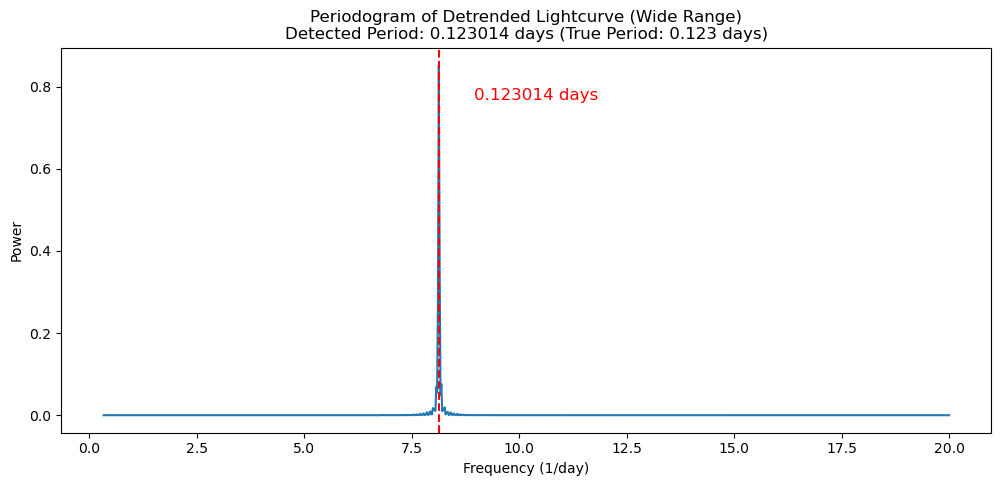

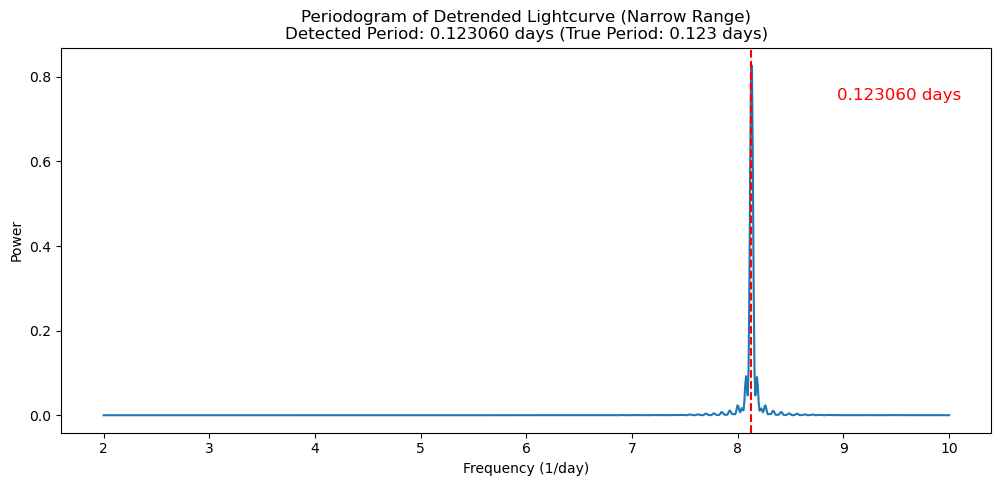

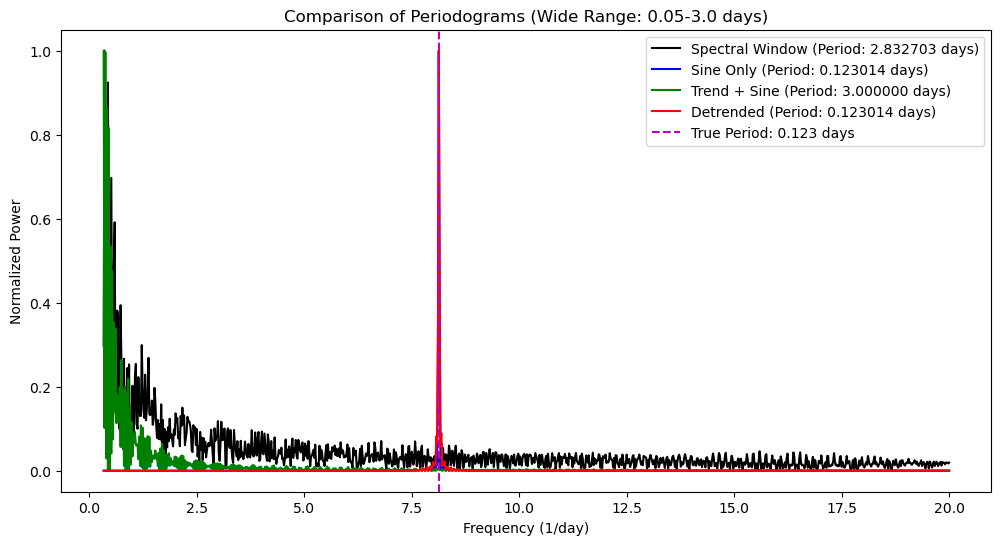

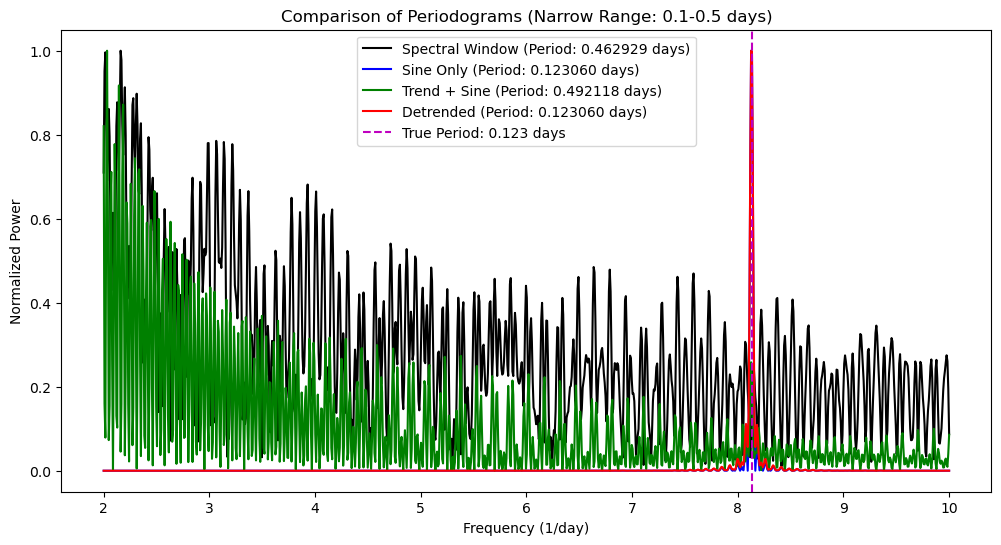


=== SUMMARY OF RESULTS ===
True Period: 0.123 days

Wide Range (0.05-3.0 days):
Spectral Window Peak Period: 2.832703 days
Detected Period (Sine Only): 0.123014 days
Detected Period (Trend + Sine): 3.000000 days
Detected Period (Detrended): 0.123014 days

Narrow Range (0.1-0.5 days):
Spectral Window Peak Period: 0.462929 days
Detected Period (Sine Only): 0.123060 days
Detected Period (Trend + Sine): 0.492118 days
Detected Period (Detrended): 0.123060 days


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.timeseries import LombScargle
%matplotlib inline

# Function for Discrete Fourier Transform (for accurate spectral window computation)
def DFT(freqmin, freqmax, nsteps, t, x):
    freqvec = np.linspace(freqmin, freqmax, int(nsteps))
    ampvec = []
    n = float(len(t))
    for freq in freqvec:
        omega = 2. * np.pi * freq
        wts = np.sin(omega * t)
        wtc = np.cos(omega * t)
        camp = np.dot(wtc, x)
        samp = np.dot(wts, x)
        amp = np.sqrt(camp**2 + samp**2)
        ampvec.append(amp)
    
    ampvec = (2./n) * np.array(ampvec)
    imax = np.argmax(ampvec)
    freqmax = freqvec[imax]
    return freqvec, ampvec, freqmax

# Create output directory for plots
output_dir = "linear_trend_demo_output"
os.makedirs(output_dir, exist_ok=True)

# Set target source name and position
target_source_name = "V606 Vul"
print(f"Searching for TESS data for {target_source_name}")

# Search for TESS cutout data for Sector 41
search_lc = lk.search_tesscut("20:21:07.7044 +29:14:09.091", sector=41)
print(f"Found {len(search_lc)} TESS sectors with data")
print(search_lc)

# Download and plot the TESS FFI cutout centered on the source
print(f"Downloading cutout for Sector {search_lc[0].mission[0]}")
tpf_cutout = search_lc[0].download(cutout_size=12, quality_bitmask='hard')

# Plot the cutout
print("Plotting the TESS image cutout...")
plt.figure(figsize=(8, 6))
tpf_cutout.plot()
plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}")
plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_cutout.png"), 
            format="png", dpi=300)
plt.show()

# Extract a lightcurve from a pixel near the center
# Get the dimensions of the cutout
rows, cols = tpf_cutout[0].shape[1:]
print(f"Cutout dimensions: {rows} x {cols} pixels")

# Choose a pixel near the center
center_row = rows // 2
center_col = cols // 2

# Create a mask for this specific pixel
pixel_mask = np.zeros((rows, cols), dtype=bool)
pixel_mask[center_row, center_col] = True

# Extract the raw lightcurve for this pixel
print(f"Extracting lightcurve from pixel ({center_row}, {center_col})")
pixel_lc = tpf_cutout.to_lightcurve(aperture_mask=pixel_mask)

# Clean up the lightcurve (remove NaNs and outliers)
pixel_lc = pixel_lc.remove_nans()
pixel_lc = pixel_lc.remove_outliers(sigma=5)

# Plot the raw lightcurve
plt.figure(figsize=(12, 5))
pixel_lc.plot(lw=1, marker='.', markersize=3, linestyle='None')
plt.title(f"{target_source_name} - Raw Lightcurve from Pixel ({center_row}, {center_col})")
plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_raw_lc.png"), 
            format="png", dpi=300)
plt.show()

# Get the time and flux values
time = pixel_lc.time.value
flux = pixel_lc.flux.value
flux_err = pixel_lc.flux_err.value if hasattr(pixel_lc, 'flux_err') and pixel_lc.flux_err is not None else None

# Calculate the min-to-max amplitude of the real lightcurve
real_flux_range = np.max(flux) - np.min(flux)
print(f"Min-to-max amplitude of real lightcurve: {real_flux_range}")

# Create a constant lightcurve using the median flux
median_flux = np.median(flux)
constant_flux = np.ones_like(flux) * median_flux

# Create a new LightCurve object with constant flux
constant_lc = lk.LightCurve(
    time=pixel_lc.time,  # Keep original time sampling
    flux=constant_flux * pixel_lc.flux.unit  # Use same units as original
)

# Plot the constant lightcurve
plt.figure(figsize=(12, 5))
constant_lc.plot(lw=1, marker='.', markersize=3, linestyle='None')
plt.title(f"{target_source_name} - Constant Lightcurve")
plt.savefig(os.path.join(output_dir, "constant_lc.png"), format="png", dpi=300)
plt.show()

# Create a sine wave modulation with 0.5% amplitude and period of 0.123 days
period = 0.123  # days
amplitude = 0.005 * median_flux  # 0.5% of the constant value (reduced from 1%)
frequency = 1.0 / period  # cycles per day
phase = 0.0  # radians

# Calculate sine wave values
sine_wave = amplitude * np.sin(2.0 * np.pi * frequency * time + phase)

# Add sine wave to constant flux
sine_modulated_flux = constant_flux + sine_wave

# Create a new LightCurve object with sine modulation
sine_lc = lk.LightCurve(
    time=pixel_lc.time,
    flux=sine_modulated_flux * pixel_lc.flux.unit
)

# Plot the sine-modulated lightcurve
plt.figure(figsize=(12, 5))
sine_lc.plot(lw=1, marker='.', markersize=3, linestyle='None')
plt.title(f"{target_source_name} - Sine-Modulated Lightcurve (Period = {period} days, Amplitude = 0.5%)")
plt.savefig(os.path.join(output_dir, "sine_modulated_lc.png"), format="png", dpi=300)
plt.show()

# Define the frequency grid for periodogram (wide range)
min_period_wide, max_period_wide = 0.05, 3.0
min_frequency_wide = 1 / max_period_wide
max_frequency_wide = 1 / min_period_wide
frequency_grid_wide = np.linspace(min_frequency_wide, max_frequency_wide, 1000)

# Define the frequency grid for periodogram (narrow range)
min_period_narrow, max_period_narrow = 0.1, 0.5
min_frequency_narrow = 1 / max_period_narrow
max_frequency_narrow = 1 / min_period_narrow
frequency_grid_narrow = np.linspace(min_frequency_narrow, max_frequency_narrow, 1000)

# Compute spectral window using DFT (proper way)
print("Computing spectral window using DFT method...")
# Create the window function (unit amplitude)
window = np.ones(len(time)) * 0.5  # 0.5 for DFT normalization

# Compute spectral window for wide range
sw_freq_wide, sw_power_wide, sw_freq_max_wide = DFT(min_frequency_wide, max_frequency_wide, 1000, time, window)
best_period_sw_wide = 1.0 / sw_freq_max_wide if sw_freq_max_wide > 0 else 0

# Compute spectral window for narrow range
sw_freq_narrow, sw_power_narrow, sw_freq_max_narrow = DFT(min_frequency_narrow, max_frequency_narrow, 1000, time, window)
best_period_sw_narrow = 1.0 / sw_freq_max_narrow if sw_freq_max_narrow > 0 else 0

# Plot the spectral window for wide range
plt.figure(figsize=(12, 5))
plt.plot(sw_freq_wide, sw_power_wide)
plt.axvline(x=sw_freq_max_wide, color='r', linestyle='--')
plt.text(sw_freq_max_wide*1.1, max(sw_power_wide)*0.9, f"{best_period_sw_wide:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Spectral Window (DFT) - Wide Range\nPeak Period: {best_period_sw_wide:.6f} days")
plt.savefig(os.path.join(output_dir, "spectral_window_wide.png"), format="png", dpi=300)
plt.show()

# Plot the spectral window for narrow range
plt.figure(figsize=(12, 5))
plt.plot(sw_freq_narrow, sw_power_narrow)
plt.axvline(x=sw_freq_max_narrow, color='r', linestyle='--')
plt.text(sw_freq_max_narrow*1.1, max(sw_power_narrow)*0.9, f"{best_period_sw_narrow:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Spectral Window (DFT) - Narrow Range\nPeak Period: {best_period_sw_narrow:.6f} days")
plt.savefig(os.path.join(output_dir, "spectral_window_narrow.png"), format="png", dpi=300)
plt.show()

# Calculate Lomb-Scargle periodogram for sine-modulated lightcurve (wide range)
ls_sine_wide = LombScargle(sine_lc.time.value, sine_lc.flux.value)
power_sine_wide = ls_sine_wide.power(frequency_grid_wide)

# Find the best period for sine-modulated lightcurve
best_idx_sine_wide = np.argmax(power_sine_wide)
best_frequency_sine_wide = frequency_grid_wide[best_idx_sine_wide]
best_period_sine_wide = 1.0 / best_frequency_sine_wide
max_power_sine_wide = power_sine_wide[best_idx_sine_wide]

# Plot the periodogram for sine-modulated lightcurve (wide range)
plt.figure(figsize=(12, 5))
plt.plot(frequency_grid_wide, power_sine_wide)
plt.axvline(x=best_frequency_sine_wide, color='r', linestyle='--')
plt.text(best_frequency_sine_wide*1.1, max_power_sine_wide*0.9, f"{best_period_sine_wide:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Periodogram of Sine-Modulated Lightcurve (Wide Range)\nDetected Period: {best_period_sine_wide:.6f} days (True Period: {period} days)")
plt.savefig(os.path.join(output_dir, "sine_periodogram_wide.png"), format="png", dpi=300)
plt.show()

# Calculate Lomb-Scargle periodogram for sine-modulated lightcurve (narrow range)
ls_sine_narrow = LombScargle(sine_lc.time.value, sine_lc.flux.value)
power_sine_narrow = ls_sine_narrow.power(frequency_grid_narrow)

# Find the best period for sine-modulated lightcurve in narrow range
best_idx_sine_narrow = np.argmax(power_sine_narrow)
best_frequency_sine_narrow = frequency_grid_narrow[best_idx_sine_narrow]
best_period_sine_narrow = 1.0 / best_frequency_sine_narrow
max_power_sine_narrow = power_sine_narrow[best_idx_sine_narrow]

# Plot the periodogram for sine-modulated lightcurve (narrow range)
plt.figure(figsize=(12, 5))
plt.plot(frequency_grid_narrow, power_sine_narrow)
plt.axvline(x=best_frequency_sine_narrow, color='r', linestyle='--')
plt.text(best_frequency_sine_narrow*1.1, max_power_sine_narrow*0.9, f"{best_period_sine_narrow:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Periodogram of Sine-Modulated Lightcurve (Narrow Range)\nDetected Period: {best_period_sine_narrow:.6f} days (True Period: {period} days)")
plt.savefig(os.path.join(output_dir, "sine_periodogram_narrow.png"), format="png", dpi=300)
plt.show()

# Add a decreasing linear trend to the sine-modulated lightcurve
# Scale time to be between 0 and 1 for the trend
time_scaled = (time - np.min(time)) / (np.max(time) - np.min(time))
# Use real amplitude from the actual lightcurve as the trend amplitude
# Make it decreasing by using (1 - time_scaled)
trend_amplitude = real_flux_range  # Using real min-to-max amplitude
linear_trend = trend_amplitude * (1 - time_scaled)  # Decreasing trend

# Add trend to the sine-modulated flux
trend_sine_flux = sine_modulated_flux + linear_trend

# Create a new LightCurve object with trend and sine modulation
trend_sine_lc = lk.LightCurve(
    time=pixel_lc.time,
    flux=trend_sine_flux * pixel_lc.flux.unit
)

# Plot the trend+sine lightcurve
plt.figure(figsize=(12, 5))
trend_sine_lc.plot(lw=1, marker='.', markersize=3, linestyle='None')
plt.title(f"{target_source_name} - Decreasing Trend + Sine-Modulated Lightcurve")
plt.savefig(os.path.join(output_dir, "trend_sine_lc.png"), format="png", dpi=300)
plt.show()

# Calculate Lomb-Scargle periodogram for trend+sine lightcurve (wide range)
ls_trend_sine_wide = LombScargle(trend_sine_lc.time.value, trend_sine_lc.flux.value)
power_trend_sine_wide = ls_trend_sine_wide.power(frequency_grid_wide)

# Find the best period for trend+sine lightcurve
best_idx_trend_sine_wide = np.argmax(power_trend_sine_wide)
best_frequency_trend_sine_wide = frequency_grid_wide[best_idx_trend_sine_wide]
best_period_trend_sine_wide = 1.0 / best_frequency_trend_sine_wide
max_power_trend_sine_wide = power_trend_sine_wide[best_idx_trend_sine_wide]

# Plot the periodogram for trend+sine lightcurve (wide range)
plt.figure(figsize=(12, 5))
plt.plot(frequency_grid_wide, power_trend_sine_wide)
plt.axvline(x=best_frequency_trend_sine_wide, color='r', linestyle='--')
plt.text(best_frequency_trend_sine_wide*1.1, max_power_trend_sine_wide*0.9, f"{best_period_trend_sine_wide:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Periodogram of Trend + Sine Lightcurve (Wide Range)\nDetected Period: {best_period_trend_sine_wide:.6f} days (True Period: {period} days)")
plt.savefig(os.path.join(output_dir, "trend_sine_periodogram_wide.png"), format="png", dpi=300)
plt.show()

# Calculate Lomb-Scargle periodogram for trend+sine lightcurve (narrow range)
ls_trend_sine_narrow = LombScargle(trend_sine_lc.time.value, trend_sine_lc.flux.value)
power_trend_sine_narrow = ls_trend_sine_narrow.power(frequency_grid_narrow)

# Find the best period for trend+sine lightcurve in narrow range
best_idx_trend_sine_narrow = np.argmax(power_trend_sine_narrow)
best_frequency_trend_sine_narrow = frequency_grid_narrow[best_idx_trend_sine_narrow]
best_period_trend_sine_narrow = 1.0 / best_frequency_trend_sine_narrow
max_power_trend_sine_narrow = power_trend_sine_narrow[best_idx_trend_sine_narrow]

# Plot the periodogram for trend+sine lightcurve (narrow range)
plt.figure(figsize=(12, 5))
plt.plot(frequency_grid_narrow, power_trend_sine_narrow)
plt.axvline(x=best_frequency_trend_sine_narrow, color='r', linestyle='--')
plt.text(best_frequency_trend_sine_narrow*1.1, max_power_trend_sine_narrow*0.9, f"{best_period_trend_sine_narrow:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Periodogram of Trend + Sine Lightcurve (Narrow Range)\nDetected Period: {best_period_trend_sine_narrow:.6f} days (True Period: {period} days)")
plt.savefig(os.path.join(output_dir, "trend_sine_periodogram_narrow.png"), format="png", dpi=300)
plt.show()

# Detrend the trend+sine lightcurve using flatten
trend_sine_flat_lc = trend_sine_lc.flatten(window_length=101, polyorder=5)

# Plot the detrended lightcurve
plt.figure(figsize=(12, 5))
trend_sine_flat_lc.plot(lw=1, marker='.', markersize=3, linestyle='None')
plt.title(f"{target_source_name} - Detrended (Trend + Sine) Lightcurve")
plt.savefig(os.path.join(output_dir, "detrended_lc.png"), format="png", dpi=300)
plt.show()

# Calculate Lomb-Scargle periodogram for detrended lightcurve (wide range)
ls_detrended_wide = LombScargle(trend_sine_flat_lc.time.value, trend_sine_flat_lc.flux.value)
power_detrended_wide = ls_detrended_wide.power(frequency_grid_wide)

# Find the best period for detrended lightcurve
best_idx_detrended_wide = np.argmax(power_detrended_wide)
best_frequency_detrended_wide = frequency_grid_wide[best_idx_detrended_wide]
best_period_detrended_wide = 1.0 / best_frequency_detrended_wide
max_power_detrended_wide = power_detrended_wide[best_idx_detrended_wide]

# Plot the periodogram for detrended lightcurve (wide range)
plt.figure(figsize=(12, 5))
plt.plot(frequency_grid_wide, power_detrended_wide)
plt.axvline(x=best_frequency_detrended_wide, color='r', linestyle='--')
plt.text(best_frequency_detrended_wide*1.1, max_power_detrended_wide*0.9, f"{best_period_detrended_wide:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Periodogram of Detrended Lightcurve (Wide Range)\nDetected Period: {best_period_detrended_wide:.6f} days (True Period: {period} days)")
plt.savefig(os.path.join(output_dir, "detrended_periodogram_wide.png"), format="png", dpi=300)
plt.show()

# Calculate Lomb-Scargle periodogram for detrended lightcurve (narrow range)
ls_detrended_narrow = LombScargle(trend_sine_flat_lc.time.value, trend_sine_flat_lc.flux.value)
power_detrended_narrow = ls_detrended_narrow.power(frequency_grid_narrow)

# Find the best period for detrended lightcurve in narrow range
best_idx_detrended_narrow = np.argmax(power_detrended_narrow)
best_frequency_detrended_narrow = frequency_grid_narrow[best_idx_detrended_narrow]
best_period_detrended_narrow = 1.0 / best_frequency_detrended_narrow
max_power_detrended_narrow = power_detrended_narrow[best_idx_detrended_narrow]

# Plot the periodogram for detrended lightcurve (narrow range)
plt.figure(figsize=(12, 5))
plt.plot(frequency_grid_narrow, power_detrended_narrow)
plt.axvline(x=best_frequency_detrended_narrow, color='r', linestyle='--')
plt.text(best_frequency_detrended_narrow*1.1, max_power_detrended_narrow*0.9, f"{best_period_detrended_narrow:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Periodogram of Detrended Lightcurve (Narrow Range)\nDetected Period: {best_period_detrended_narrow:.6f} days (True Period: {period} days)")
plt.savefig(os.path.join(output_dir, "detrended_periodogram_narrow.png"), format="png", dpi=300)
plt.show()

# Compare all four periodograms on one plot (wide range)
plt.figure(figsize=(12, 6))

# Normalize powers for better comparison
norm_power_sw_wide = sw_power_wide / np.max(sw_power_wide)
norm_power_sine_wide = power_sine_wide / np.max(power_sine_wide)
norm_power_trend_sine_wide = power_trend_sine_wide / np.max(power_trend_sine_wide)
norm_power_detrended_wide = power_detrended_wide / np.max(power_detrended_wide)

plt.plot(sw_freq_wide, norm_power_sw_wide, 'k-', label=f'Spectral Window (Period: {best_period_sw_wide:.6f} days)')
plt.plot(frequency_grid_wide, norm_power_sine_wide, 'b-', label=f'Sine Only (Period: {best_period_sine_wide:.6f} days)')
plt.plot(frequency_grid_wide, norm_power_trend_sine_wide, 'g-', label=f'Trend + Sine (Period: {best_period_trend_sine_wide:.6f} days)')
plt.plot(frequency_grid_wide, norm_power_detrended_wide, 'r-', label=f'Detrended (Period: {best_period_detrended_wide:.6f} days)')

# Mark the true period
true_frequency = 1.0 / period
plt.axvline(x=true_frequency, color='m', linestyle='--', label=f'True Period: {period} days')

plt.xlabel('Frequency (1/day)')
plt.ylabel('Normalized Power')
plt.title(f"Comparison of Periodograms (Wide Range: 0.05-3.0 days)")
plt.legend()
plt.savefig(os.path.join(output_dir, "periodogram_comparison_wide.png"), format="png", dpi=300)
plt.show()

# Compare all four periodograms on one plot (narrow range)
plt.figure(figsize=(12, 6))

# Normalize powers for better comparison
norm_power_sw_narrow = sw_power_narrow / np.max(sw_power_narrow)
norm_power_sine_narrow = power_sine_narrow / np.max(power_sine_narrow)
norm_power_trend_sine_narrow = power_trend_sine_narrow / np.max(power_trend_sine_narrow)
norm_power_detrended_narrow = power_detrended_narrow / np.max(power_detrended_narrow)

plt.plot(sw_freq_narrow, norm_power_sw_narrow, 'k-', label=f'Spectral Window (Period: {best_period_sw_narrow:.6f} days)')
plt.plot(frequency_grid_narrow, norm_power_sine_narrow, 'b-', label=f'Sine Only (Period: {best_period_sine_narrow:.6f} days)')
plt.plot(frequency_grid_narrow, norm_power_trend_sine_narrow, 'g-', label=f'Trend + Sine (Period: {best_period_trend_sine_narrow:.6f} days)')
plt.plot(frequency_grid_narrow, norm_power_detrended_narrow, 'r-', label=f'Detrended (Period: {best_period_detrended_narrow:.6f} days)')

# Mark the true period
true_frequency = 1.0 / period
plt.axvline(x=true_frequency, color='m', linestyle='--', label=f'True Period: {period} days')

plt.xlabel('Frequency (1/day)')
plt.ylabel('Normalized Power')
plt.title(f"Comparison of Periodograms (Narrow Range: 0.1-0.5 days)")
plt.legend()
plt.savefig(os.path.join(output_dir, "periodogram_comparison_narrow.png"), format="png", dpi=300)
plt.show()

# Print summary of the results
print("\n=== SUMMARY OF RESULTS ===")
print(f"True Period: {period} days")
print("\nWide Range (0.05-3.0 days):")
print(f"Spectral Window Peak Period: {best_period_sw_wide:.6f} days")
print(f"Detected Period (Sine Only): {best_period_sine_wide:.6f} days")
print(f"Detected Period (Trend + Sine): {best_period_trend_sine_wide:.6f} days")
print(f"Detected Period (Detrended): {best_period_detrended_wide:.6f} days")

print("\nNarrow Range (0.1-0.5 days):")
print(f"Spectral Window Peak Period: {best_period_sw_narrow:.6f} days")
print(f"Detected Period (Sine Only): {best_period_sine_narrow:.6f} days")
print(f"Detected Period (Trend + Sine): {best_period_trend_sine_narrow:.6f} days")
print(f"Detected Period (Detrended): {best_period_detrended_narrow:.6f} days")



## Sine wave and a Gaussian trend

In this second simulation, we replace the linear trend with a Gaussian-shaped trend to test detrending efficacy with a more complex, non-linear trend. This represents a scenario closer to many astrophysical phenomena, such as nova eruption profiles or stellar outbursts.

The Gaussian trend is constructed with the following parameters:
1. **Peak position**: Located at 1/3 of the total lightcurve duration from the start
2. **Width**: Standard deviation equal to 1/3 of the lightcurve duration
3. **Amplitude**: Scaled to match the min-to-max range of the original TESS pixel data

This Gaussian trend presents a greater challenge for period detection compared to the linear trend because:
- It introduces more complex frequency content into the periodogram
- It has a more localized effect on the lightcurve, creating a steeper rise and fall
- It better mimics the characteristic profile of transient astronomical events

As with the linear trend simulation, we:
- Display the Gaussian trend by itself to illustrate its shape and amplitude
- Generate periodograms for the sine-only, Gaussian+sine, and detrended lightcurves
- Compare the results across wide and narrow period ranges
- Quantify the detection accuracy before and after detrending

Searching for TESS data for V606 Vul
Found 1 TESS sectors with data
SearchResult containing 1 data products.

 #     mission     year  author exptime         target_name         distance
                                   s                                 arcsec 
--- -------------- ---- ------- ------- --------------------------- --------
  0 TESS Sector 41 2021 TESScut     475 20:21:07.7044 +29:14:09.091      0.0
Plotting the TESS image cutout...


<Figure size 800x600 with 0 Axes>

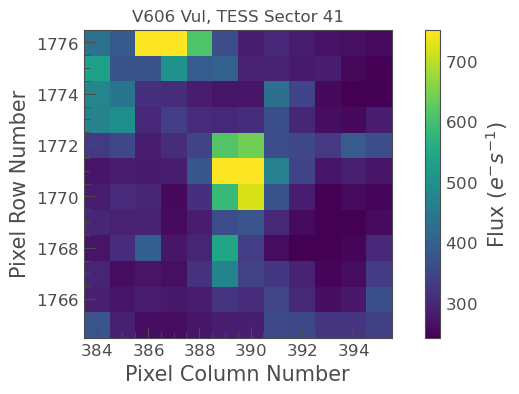

Cutout dimensions: 12 x 12 pixels
Extracting lightcurve from pixel (6, 6)


<Figure size 1200x500 with 0 Axes>

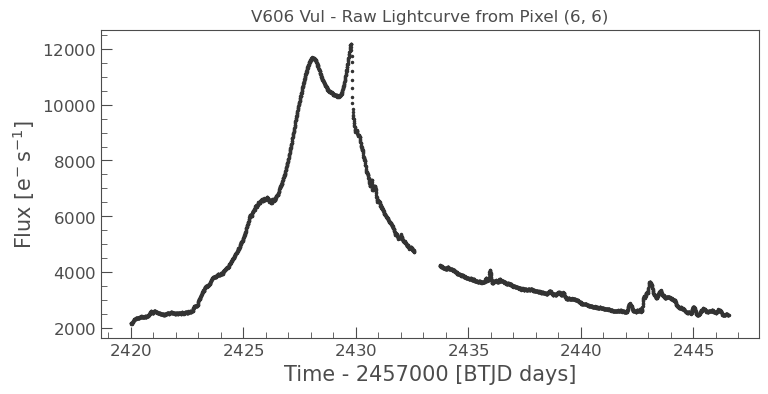

Min-to-max amplitude of real lightcurve: 10030.787109375


<Figure size 1200x500 with 0 Axes>

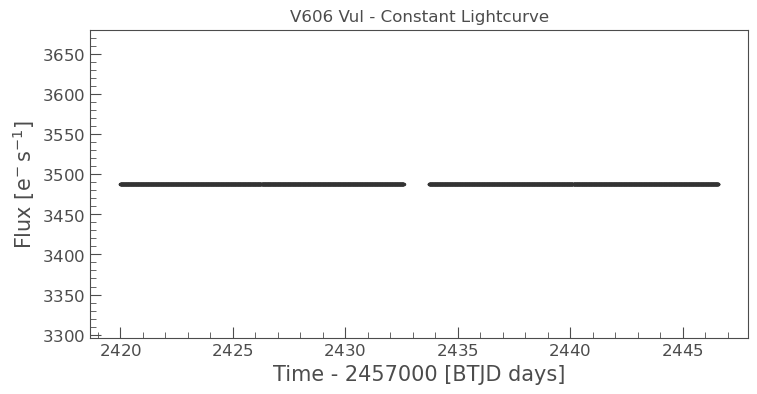

<Figure size 1200x500 with 0 Axes>

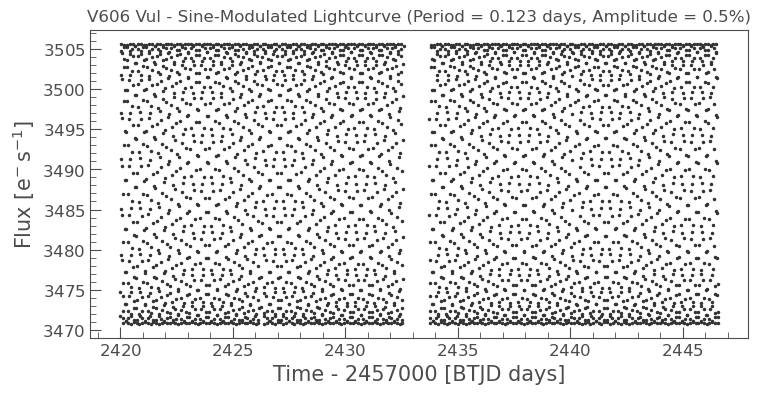

Computing spectral window using DFT method...


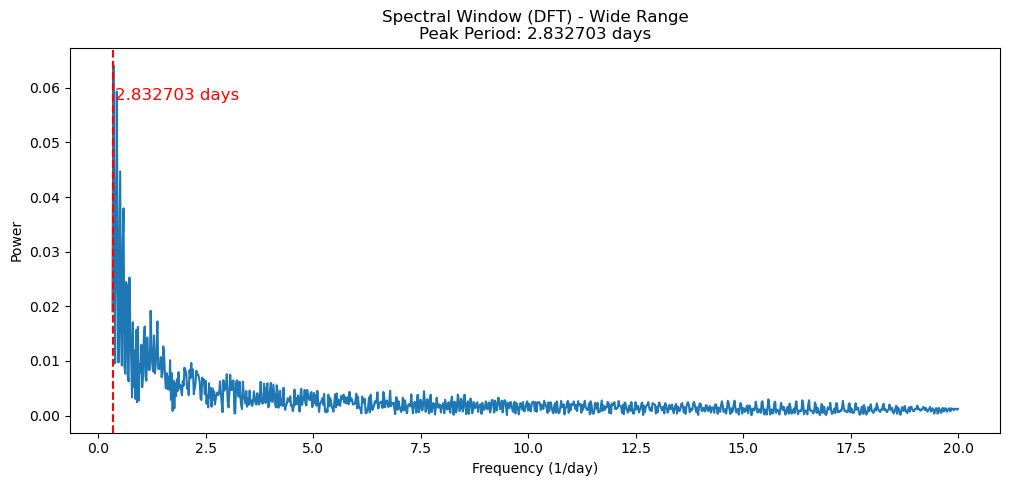

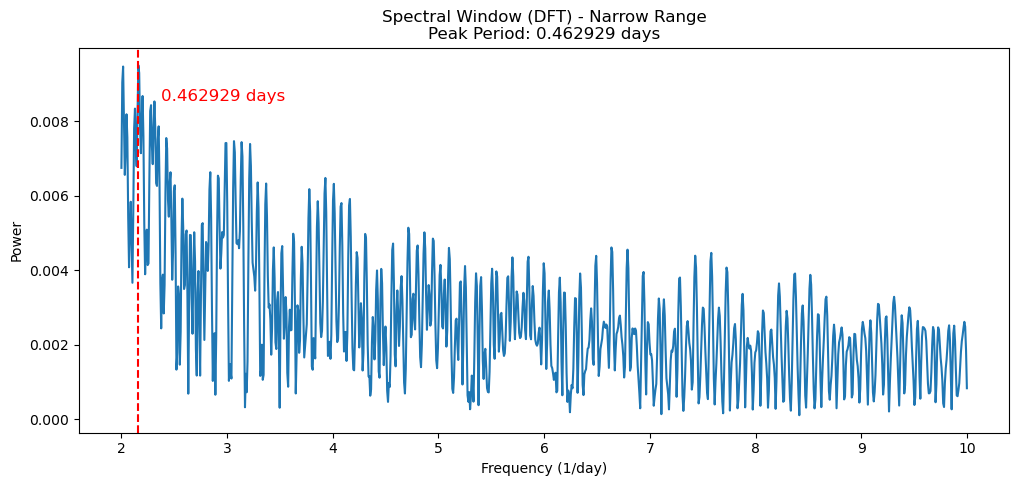

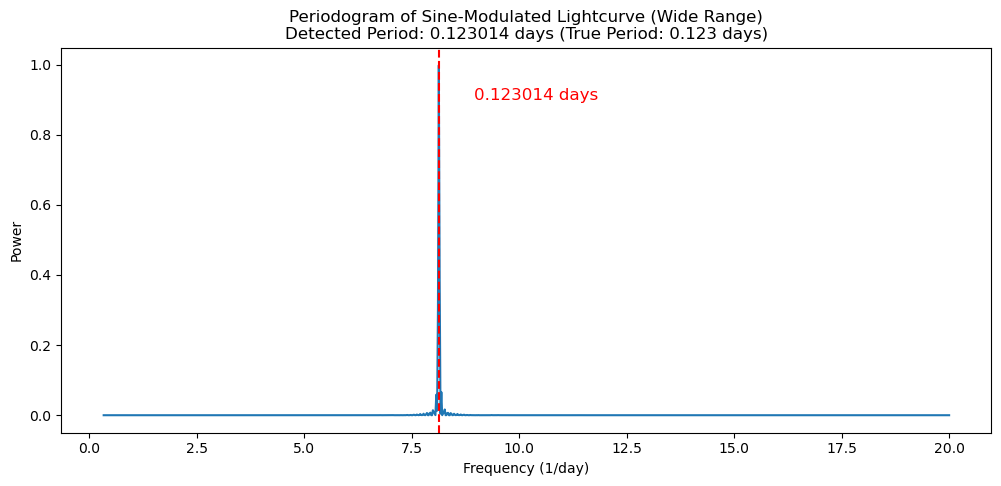

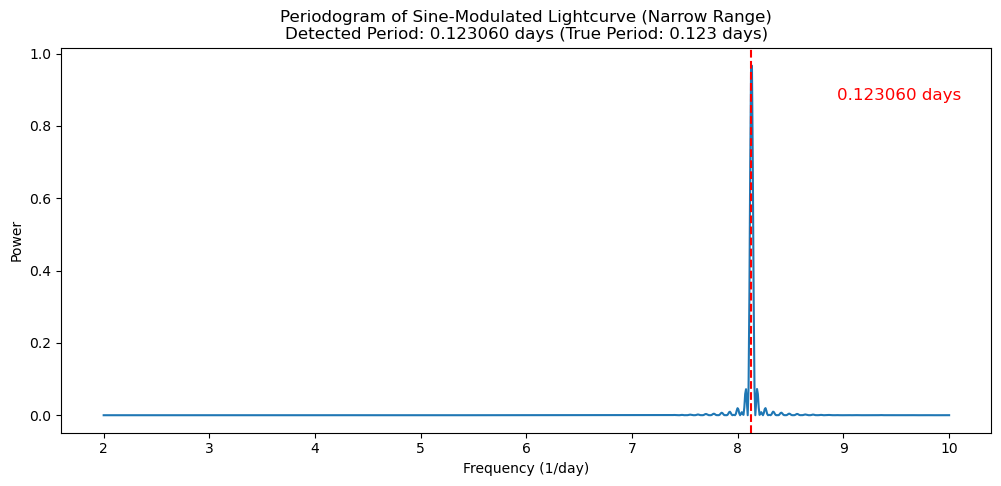

Lightcurve duration: 26.58 days


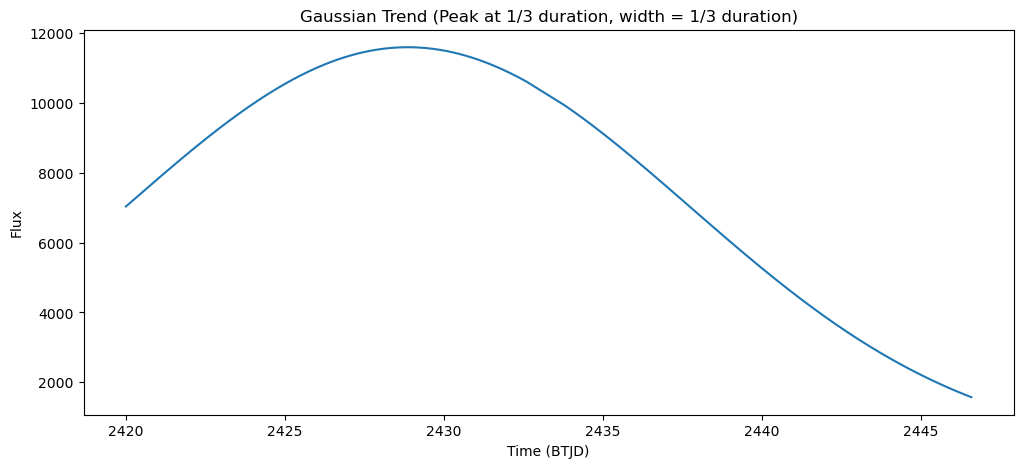

<Figure size 1200x500 with 0 Axes>

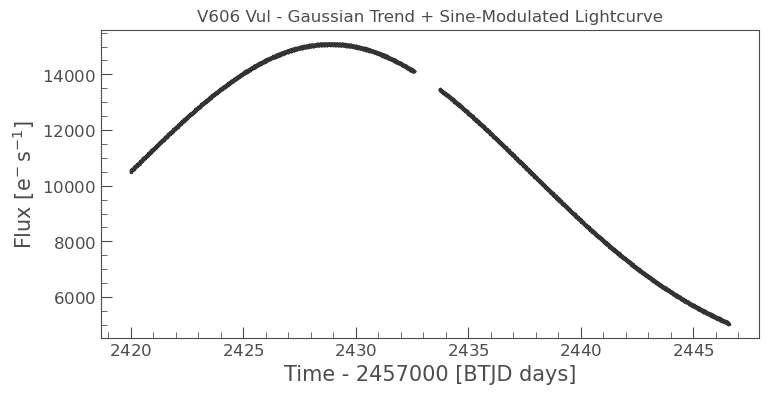

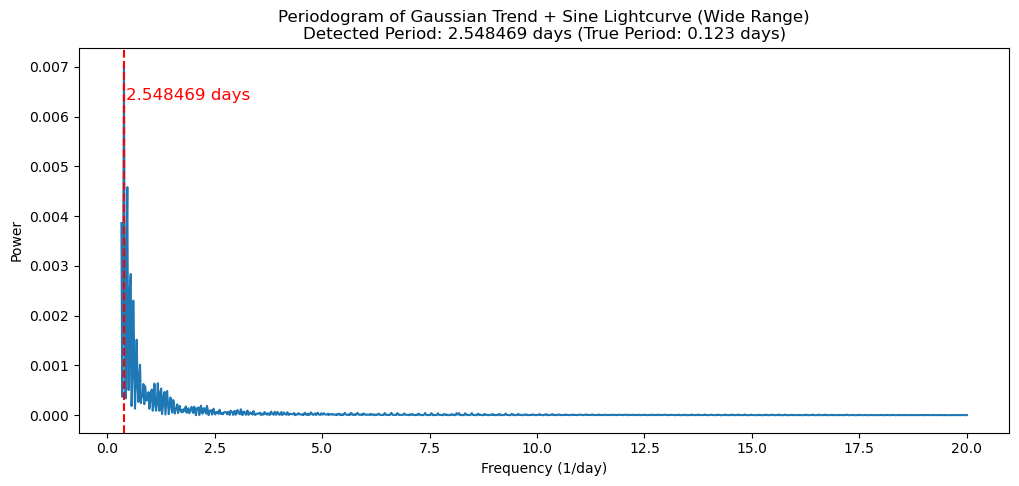

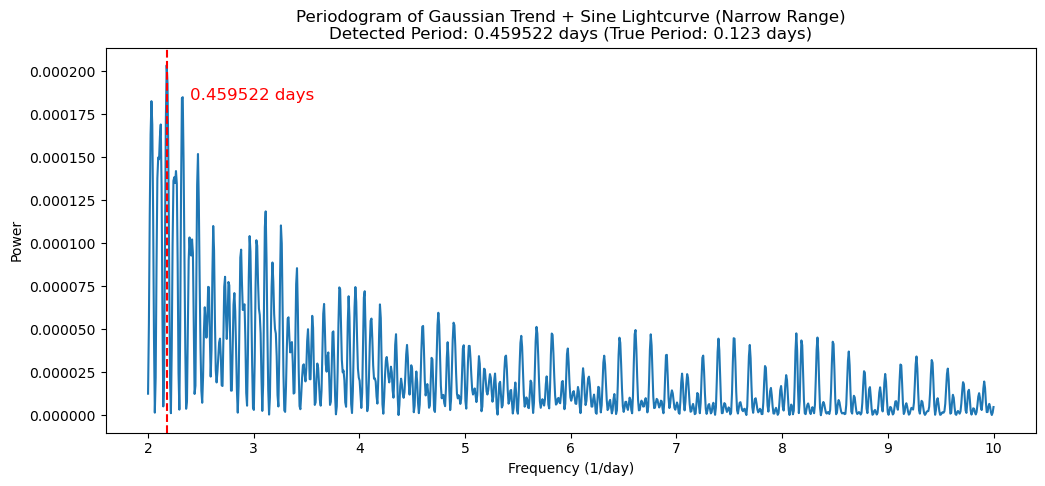

<Figure size 1200x500 with 0 Axes>

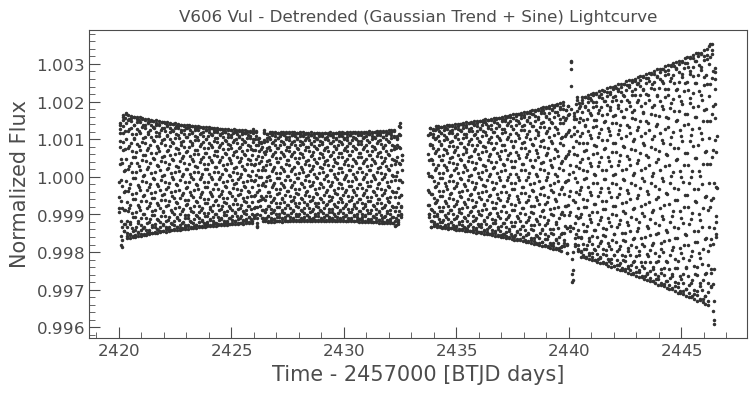

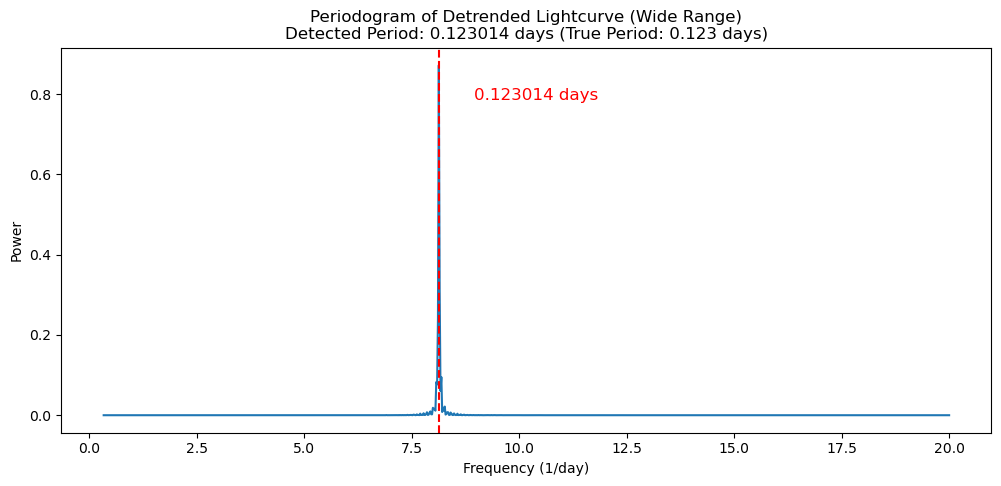

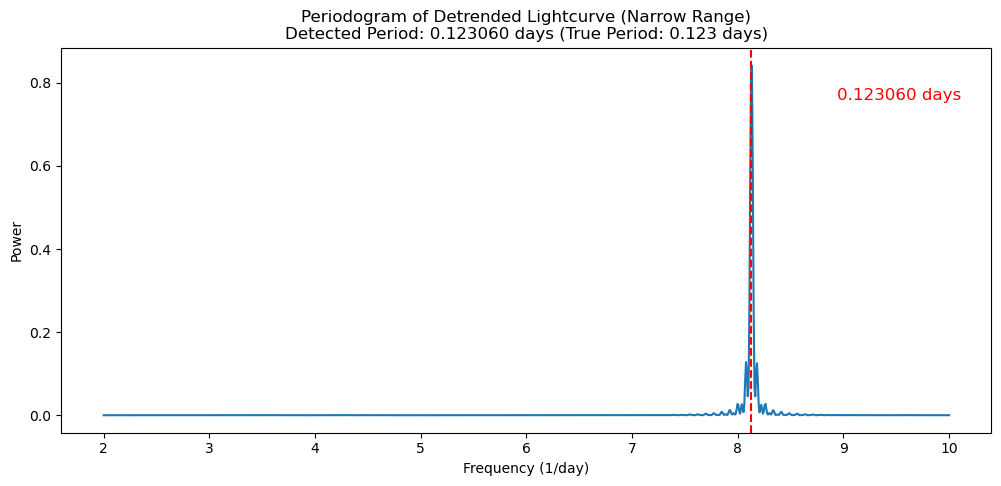

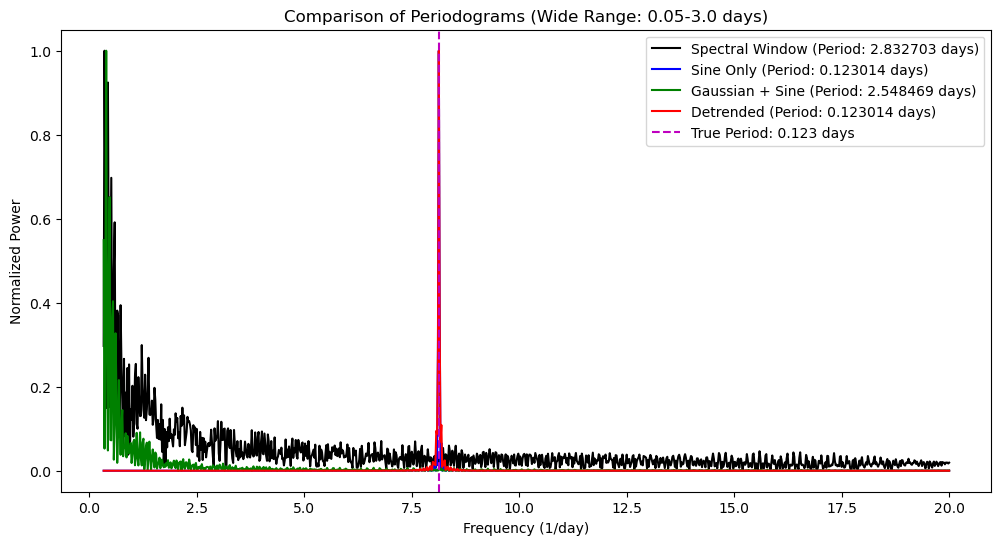

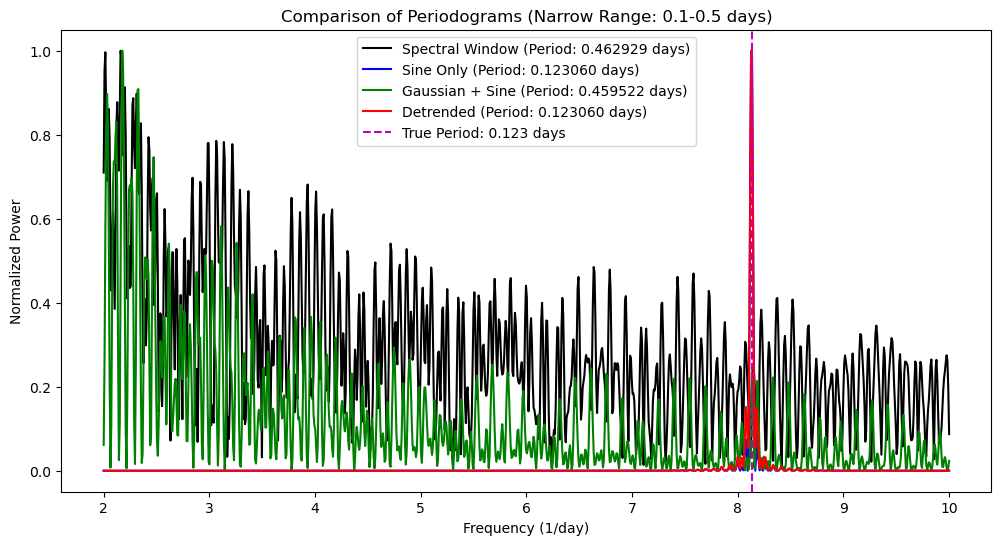


=== SUMMARY OF RESULTS ===
True Period: 0.123 days

Wide Range (0.05-3.0 days):
Spectral Window Peak Period: 2.832703 days
Detected Period (Sine Only): 0.123014 days
Detected Period (Gaussian + Sine): 2.548469 days
Detected Period (Detrended): 0.123014 days

Narrow Range (0.1-0.5 days):
Spectral Window Peak Period: 0.462929 days
Detected Period (Sine Only): 0.123060 days
Detected Period (Gaussian + Sine): 0.459522 days
Detected Period (Detrended): 0.123060 days


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.timeseries import LombScargle
from scipy.stats import norm
%matplotlib inline

# Function for Discrete Fourier Transform (for accurate spectral window computation)
def DFT(freqmin, freqmax, nsteps, t, x):
    freqvec = np.linspace(freqmin, freqmax, int(nsteps))
    ampvec = []
    n = float(len(t))
    for freq in freqvec:
        omega = 2. * np.pi * freq
        wts = np.sin(omega * t)
        wtc = np.cos(omega * t)
        camp = np.dot(wtc, x)
        samp = np.dot(wts, x)
        amp = np.sqrt(camp**2 + samp**2)
        ampvec.append(amp)
    
    ampvec = (2./n) * np.array(ampvec)
    imax = np.argmax(ampvec)
    freqmax = freqvec[imax]
    return freqvec, ampvec, freqmax

# Create output directory for plots
output_dir = "gaussian_trend_demo_output"
os.makedirs(output_dir, exist_ok=True)

# Set target source name and position
target_source_name = "V606 Vul"
print(f"Searching for TESS data for {target_source_name}")

# Search for TESS cutout data for Sector 41
search_lc = lk.search_tesscut("20:21:07.7044 +29:14:09.091", sector=41)
print(f"Found {len(search_lc)} TESS sectors with data")
print(search_lc)

# Download and plot the TESS FFI cutout centered on the source
print(f"Downloading cutout for Sector {search_lc[0].mission[0]}")
tpf_cutout = search_lc[0].download(cutout_size=12, quality_bitmask='hard')

# Plot the cutout
print("Plotting the TESS image cutout...")
plt.figure(figsize=(8, 6))
tpf_cutout.plot()
plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}")
plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_cutout.png"), 
            format="png", dpi=300)
plt.show()

# Extract a lightcurve from a pixel near the center
# Get the dimensions of the cutout
rows, cols = tpf_cutout[0].shape[1:]
print(f"Cutout dimensions: {rows} x {cols} pixels")

# Choose a pixel near the center
center_row = rows // 2
center_col = cols // 2

# Create a mask for this specific pixel
pixel_mask = np.zeros((rows, cols), dtype=bool)
pixel_mask[center_row, center_col] = True

# Extract the raw lightcurve for this pixel
print(f"Extracting lightcurve from pixel ({center_row}, {center_col})")
pixel_lc = tpf_cutout.to_lightcurve(aperture_mask=pixel_mask)

# Clean up the lightcurve (remove NaNs and outliers)
pixel_lc = pixel_lc.remove_nans()
pixel_lc = pixel_lc.remove_outliers(sigma=5)

# Plot the raw lightcurve
plt.figure(figsize=(12, 5))
pixel_lc.plot(lw=1, marker='.', markersize=3, linestyle='None')
plt.title(f"{target_source_name} - Raw Lightcurve from Pixel ({center_row}, {center_col})")
plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_raw_lc.png"), 
            format="png", dpi=300)
plt.show()

# Get the time and flux values
time = pixel_lc.time.value
flux = pixel_lc.flux.value
flux_err = pixel_lc.flux_err.value if hasattr(pixel_lc, 'flux_err') and pixel_lc.flux_err is not None else None

# Calculate the min-to-max amplitude of the real lightcurve
real_flux_range = np.max(flux) - np.min(flux)
print(f"Min-to-max amplitude of real lightcurve: {real_flux_range}")

# Create a constant lightcurve using the median flux
median_flux = np.median(flux)
constant_flux = np.ones_like(flux) * median_flux

# Create a new LightCurve object with constant flux
constant_lc = lk.LightCurve(
    time=pixel_lc.time,  # Keep original time sampling
    flux=constant_flux * pixel_lc.flux.unit  # Use same units as original
)

# Plot the constant lightcurve
plt.figure(figsize=(12, 5))
constant_lc.plot(lw=1, marker='.', markersize=3, linestyle='None')
plt.title(f"{target_source_name} - Constant Lightcurve")
plt.savefig(os.path.join(output_dir, "constant_lc.png"), format="png", dpi=300)
plt.show()

# Create a sine wave modulation with 0.5% amplitude and period of 0.123 days
period = 0.123  # days
amplitude = 0.005 * median_flux  # 0.5% of the constant value
frequency = 1.0 / period  # cycles per day
phase = 0.0  # radians

# Calculate sine wave values
sine_wave = amplitude * np.sin(2.0 * np.pi * frequency * time + phase)

# Add sine wave to constant flux
sine_modulated_flux = constant_flux + sine_wave

# Create a new LightCurve object with sine modulation
sine_lc = lk.LightCurve(
    time=pixel_lc.time,
    flux=sine_modulated_flux * pixel_lc.flux.unit
)

# Plot the sine-modulated lightcurve
plt.figure(figsize=(12, 5))
sine_lc.plot(lw=1, marker='.', markersize=3, linestyle='None')
plt.title(f"{target_source_name} - Sine-Modulated Lightcurve (Period = {period} days, Amplitude = 0.5%)")
plt.savefig(os.path.join(output_dir, "sine_modulated_lc.png"), format="png", dpi=300)
plt.show()

# Define the frequency grid for periodogram (wide range)
min_period_wide, max_period_wide = 0.05, 3.0
min_frequency_wide = 1 / max_period_wide
max_frequency_wide = 1 / min_period_wide
frequency_grid_wide = np.linspace(min_frequency_wide, max_frequency_wide, 1000)

# Define the frequency grid for periodogram (narrow range)
min_period_narrow, max_period_narrow = 0.1, 0.5
min_frequency_narrow = 1 / max_period_narrow
max_frequency_narrow = 1 / min_period_narrow
frequency_grid_narrow = np.linspace(min_frequency_narrow, max_frequency_narrow, 1000)

# Compute spectral window using DFT (proper way)
print("Computing spectral window using DFT method...")
# Create the window function (unit amplitude)
window = np.ones(len(time)) * 0.5  # 0.5 for DFT normalization

# Compute spectral window for wide range
sw_freq_wide, sw_power_wide, sw_freq_max_wide = DFT(min_frequency_wide, max_frequency_wide, 1000, time, window)
best_period_sw_wide = 1.0 / sw_freq_max_wide if sw_freq_max_wide > 0 else 0

# Compute spectral window for narrow range
sw_freq_narrow, sw_power_narrow, sw_freq_max_narrow = DFT(min_frequency_narrow, max_frequency_narrow, 1000, time, window)
best_period_sw_narrow = 1.0 / sw_freq_max_narrow if sw_freq_max_narrow > 0 else 0

# Plot the spectral window for wide range
plt.figure(figsize=(12, 5))
plt.plot(sw_freq_wide, sw_power_wide)
plt.axvline(x=sw_freq_max_wide, color='r', linestyle='--')
plt.text(sw_freq_max_wide*1.1, max(sw_power_wide)*0.9, f"{best_period_sw_wide:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Spectral Window (DFT) - Wide Range\nPeak Period: {best_period_sw_wide:.6f} days")
plt.savefig(os.path.join(output_dir, "spectral_window_wide.png"), format="png", dpi=300)
plt.show()

# Plot the spectral window for narrow range
plt.figure(figsize=(12, 5))
plt.plot(sw_freq_narrow, sw_power_narrow)
plt.axvline(x=sw_freq_max_narrow, color='r', linestyle='--')
plt.text(sw_freq_max_narrow*1.1, max(sw_power_narrow)*0.9, f"{best_period_sw_narrow:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Spectral Window (DFT) - Narrow Range\nPeak Period: {best_period_sw_narrow:.6f} days")
plt.savefig(os.path.join(output_dir, "spectral_window_narrow.png"), format="png", dpi=300)
plt.show()

# Calculate Lomb-Scargle periodogram for sine-modulated lightcurve (wide range)
ls_sine_wide = LombScargle(sine_lc.time.value, sine_lc.flux.value)
power_sine_wide = ls_sine_wide.power(frequency_grid_wide)

# Find the best period for sine-modulated lightcurve
best_idx_sine_wide = np.argmax(power_sine_wide)
best_frequency_sine_wide = frequency_grid_wide[best_idx_sine_wide]
best_period_sine_wide = 1.0 / best_frequency_sine_wide
max_power_sine_wide = power_sine_wide[best_idx_sine_wide]

# Plot the periodogram for sine-modulated lightcurve (wide range)
plt.figure(figsize=(12, 5))
plt.plot(frequency_grid_wide, power_sine_wide)
plt.axvline(x=best_frequency_sine_wide, color='r', linestyle='--')
plt.text(best_frequency_sine_wide*1.1, max_power_sine_wide*0.9, f"{best_period_sine_wide:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Periodogram of Sine-Modulated Lightcurve (Wide Range)\nDetected Period: {best_period_sine_wide:.6f} days (True Period: {period} days)")
plt.savefig(os.path.join(output_dir, "sine_periodogram_wide.png"), format="png", dpi=300)
plt.show()

# Calculate Lomb-Scargle periodogram for sine-modulated lightcurve (narrow range)
ls_sine_narrow = LombScargle(sine_lc.time.value, sine_lc.flux.value)
power_sine_narrow = ls_sine_narrow.power(frequency_grid_narrow)

# Find the best period for sine-modulated lightcurve in narrow range
best_idx_sine_narrow = np.argmax(power_sine_narrow)
best_frequency_sine_narrow = frequency_grid_narrow[best_idx_sine_narrow]
best_period_sine_narrow = 1.0 / best_frequency_sine_narrow
max_power_sine_narrow = power_sine_narrow[best_idx_sine_narrow]

# Plot the periodogram for sine-modulated lightcurve (narrow range)
plt.figure(figsize=(12, 5))
plt.plot(frequency_grid_narrow, power_sine_narrow)
plt.axvline(x=best_frequency_sine_narrow, color='r', linestyle='--')
plt.text(best_frequency_sine_narrow*1.1, max_power_sine_narrow*0.9, f"{best_period_sine_narrow:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Periodogram of Sine-Modulated Lightcurve (Narrow Range)\nDetected Period: {best_period_sine_narrow:.6f} days (True Period: {period} days)")
plt.savefig(os.path.join(output_dir, "sine_periodogram_narrow.png"), format="png", dpi=300)
plt.show()

# Create a Gaussian trend peaking at 1/3 of the lightcurve duration
# Get the duration of the lightcurve
time_duration = np.max(time) - np.min(time)
print(f"Lightcurve duration: {time_duration:.2f} days")

# Set the mean (peak) at 1/3 of the duration from the start
gaussian_mean = np.min(time) + time_duration / 3

# Set the standard deviation to 1/3 of the duration
gaussian_std = time_duration / 3

# Create the Gaussian trend with amplitude equal to the min-to-max range of the real lightcurve
gaussian_trend = real_flux_range * norm.pdf(time, gaussian_mean, gaussian_std)

# Scale the Gaussian to have the same min-to-max range as the original lightcurve
gaussian_trend = gaussian_trend * (real_flux_range / (np.max(gaussian_trend) - np.min(gaussian_trend)))

# Add the Gaussian trend to the sine-modulated flux
gaussian_sine_flux = sine_modulated_flux + gaussian_trend

# Create a new LightCurve object with Gaussian trend and sine modulation
gaussian_sine_lc = lk.LightCurve(
    time=pixel_lc.time,
    flux=gaussian_sine_flux * pixel_lc.flux.unit
)

# Plot the Gaussian trend
plt.figure(figsize=(12, 5))
plt.plot(time, gaussian_trend)
plt.title(f"Gaussian Trend (Peak at 1/3 duration, width = 1/3 duration)")
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux')
plt.savefig(os.path.join(output_dir, "gaussian_trend.png"), format="png", dpi=300)
plt.show()

# Plot the Gaussian+sine lightcurve
plt.figure(figsize=(12, 5))
gaussian_sine_lc.plot(lw=1, marker='.', markersize=3, linestyle='None')
plt.title(f"{target_source_name} - Gaussian Trend + Sine-Modulated Lightcurve")
plt.savefig(os.path.join(output_dir, "gaussian_sine_lc.png"), format="png", dpi=300)
plt.show()

# Calculate Lomb-Scargle periodogram for Gaussian+sine lightcurve (wide range)
ls_gaussian_sine_wide = LombScargle(gaussian_sine_lc.time.value, gaussian_sine_lc.flux.value)
power_gaussian_sine_wide = ls_gaussian_sine_wide.power(frequency_grid_wide)

# Find the best period for Gaussian+sine lightcurve
best_idx_gaussian_sine_wide = np.argmax(power_gaussian_sine_wide)
best_frequency_gaussian_sine_wide = frequency_grid_wide[best_idx_gaussian_sine_wide]
best_period_gaussian_sine_wide = 1.0 / best_frequency_gaussian_sine_wide
max_power_gaussian_sine_wide = power_gaussian_sine_wide[best_idx_gaussian_sine_wide]

# Plot the periodogram for Gaussian+sine lightcurve (wide range)
plt.figure(figsize=(12, 5))
plt.plot(frequency_grid_wide, power_gaussian_sine_wide)
plt.axvline(x=best_frequency_gaussian_sine_wide, color='r', linestyle='--')
plt.text(best_frequency_gaussian_sine_wide*1.1, max_power_gaussian_sine_wide*0.9, f"{best_period_gaussian_sine_wide:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Periodogram of Gaussian Trend + Sine Lightcurve (Wide Range)\nDetected Period: {best_period_gaussian_sine_wide:.6f} days (True Period: {period} days)")
plt.savefig(os.path.join(output_dir, "gaussian_sine_periodogram_wide.png"), format="png", dpi=300)
plt.show()

# Calculate Lomb-Scargle periodogram for Gaussian+sine lightcurve (narrow range)
ls_gaussian_sine_narrow = LombScargle(gaussian_sine_lc.time.value, gaussian_sine_lc.flux.value)
power_gaussian_sine_narrow = ls_gaussian_sine_narrow.power(frequency_grid_narrow)

# Find the best period for Gaussian+sine lightcurve in narrow range
best_idx_gaussian_sine_narrow = np.argmax(power_gaussian_sine_narrow)
best_frequency_gaussian_sine_narrow = frequency_grid_narrow[best_idx_gaussian_sine_narrow]
best_period_gaussian_sine_narrow = 1.0 / best_frequency_gaussian_sine_narrow
max_power_gaussian_sine_narrow = power_gaussian_sine_narrow[best_idx_gaussian_sine_narrow]

# Plot the periodogram for Gaussian+sine lightcurve (narrow range)
plt.figure(figsize=(12, 5))
plt.plot(frequency_grid_narrow, power_gaussian_sine_narrow)
plt.axvline(x=best_frequency_gaussian_sine_narrow, color='r', linestyle='--')
plt.text(best_frequency_gaussian_sine_narrow*1.1, max_power_gaussian_sine_narrow*0.9, f"{best_period_gaussian_sine_narrow:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Periodogram of Gaussian Trend + Sine Lightcurve (Narrow Range)\nDetected Period: {best_period_gaussian_sine_narrow:.6f} days (True Period: {period} days)")
plt.savefig(os.path.join(output_dir, "gaussian_sine_periodogram_narrow.png"), format="png", dpi=300)
plt.show()

# Detrend the Gaussian+sine lightcurve using flatten
gaussian_sine_flat_lc = gaussian_sine_lc.flatten(window_length=101, polyorder=5)

# Plot the detrended lightcurve
plt.figure(figsize=(12, 5))
gaussian_sine_flat_lc.plot(lw=1, marker='.', markersize=3, linestyle='None')
plt.title(f"{target_source_name} - Detrended (Gaussian Trend + Sine) Lightcurve")
plt.savefig(os.path.join(output_dir, "detrended_gaussian_lc.png"), format="png", dpi=300)
plt.show()

# Calculate Lomb-Scargle periodogram for detrended lightcurve (wide range)
ls_detrended_wide = LombScargle(gaussian_sine_flat_lc.time.value, gaussian_sine_flat_lc.flux.value)
power_detrended_wide = ls_detrended_wide.power(frequency_grid_wide)

# Find the best period for detrended lightcurve
best_idx_detrended_wide = np.argmax(power_detrended_wide)
best_frequency_detrended_wide = frequency_grid_wide[best_idx_detrended_wide]
best_period_detrended_wide = 1.0 / best_frequency_detrended_wide
max_power_detrended_wide = power_detrended_wide[best_idx_detrended_wide]

# Plot the periodogram for detrended lightcurve (wide range)
plt.figure(figsize=(12, 5))
plt.plot(frequency_grid_wide, power_detrended_wide)
plt.axvline(x=best_frequency_detrended_wide, color='r', linestyle='--')
plt.text(best_frequency_detrended_wide*1.1, max_power_detrended_wide*0.9, f"{best_period_detrended_wide:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Periodogram of Detrended Lightcurve (Wide Range)\nDetected Period: {best_period_detrended_wide:.6f} days (True Period: {period} days)")
plt.savefig(os.path.join(output_dir, "detrended_gaussian_periodogram_wide.png"), format="png", dpi=300)
plt.show()

# Calculate Lomb-Scargle periodogram for detrended lightcurve (narrow range)
ls_detrended_narrow = LombScargle(gaussian_sine_flat_lc.time.value, gaussian_sine_flat_lc.flux.value)
power_detrended_narrow = ls_detrended_narrow.power(frequency_grid_narrow)

# Find the best period for detrended lightcurve in narrow range
best_idx_detrended_narrow = np.argmax(power_detrended_narrow)
best_frequency_detrended_narrow = frequency_grid_narrow[best_idx_detrended_narrow]
best_period_detrended_narrow = 1.0 / best_frequency_detrended_narrow
max_power_detrended_narrow = power_detrended_narrow[best_idx_detrended_narrow]

# Plot the periodogram for detrended lightcurve (narrow range)
plt.figure(figsize=(12, 5))
plt.plot(frequency_grid_narrow, power_detrended_narrow)
plt.axvline(x=best_frequency_detrended_narrow, color='r', linestyle='--')
plt.text(best_frequency_detrended_narrow*1.1, max_power_detrended_narrow*0.9, f"{best_period_detrended_narrow:.6f} days", 
         color='r', fontsize=12)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title(f"Periodogram of Detrended Lightcurve (Narrow Range)\nDetected Period: {best_period_detrended_narrow:.6f} days (True Period: {period} days)")
plt.savefig(os.path.join(output_dir, "detrended_gaussian_periodogram_narrow.png"), format="png", dpi=300)
plt.show()

# Compare all four periodograms on one plot (wide range)
plt.figure(figsize=(12, 6))

# Normalize powers for better comparison
norm_power_sw_wide = sw_power_wide / np.max(sw_power_wide)
norm_power_sine_wide = power_sine_wide / np.max(power_sine_wide)
norm_power_gaussian_sine_wide = power_gaussian_sine_wide / np.max(power_gaussian_sine_wide)
norm_power_detrended_wide = power_detrended_wide / np.max(power_detrended_wide)

plt.plot(sw_freq_wide, norm_power_sw_wide, 'k-', label=f'Spectral Window (Period: {best_period_sw_wide:.6f} days)')
plt.plot(frequency_grid_wide, norm_power_sine_wide, 'b-', label=f'Sine Only (Period: {best_period_sine_wide:.6f} days)')
plt.plot(frequency_grid_wide, norm_power_gaussian_sine_wide, 'g-', label=f'Gaussian + Sine (Period: {best_period_gaussian_sine_wide:.6f} days)')
plt.plot(frequency_grid_wide, norm_power_detrended_wide, 'r-', label=f'Detrended (Period: {best_period_detrended_wide:.6f} days)')

# Mark the true period
true_frequency = 1.0 / period
plt.axvline(x=true_frequency, color='m', linestyle='--', label=f'True Period: {period} days')

plt.xlabel('Frequency (1/day)')
plt.ylabel('Normalized Power')
plt.title(f"Comparison of Periodograms (Wide Range: 0.05-3.0 days)")
plt.legend()
plt.savefig(os.path.join(output_dir, "periodogram_comparison_wide.png"), format="png", dpi=300)
plt.show()

# Compare all four periodograms on one plot (narrow range)
plt.figure(figsize=(12, 6))

# Normalize powers for better comparison
norm_power_sw_narrow = sw_power_narrow / np.max(sw_power_narrow)
norm_power_sine_narrow = power_sine_narrow / np.max(power_sine_narrow)
norm_power_gaussian_sine_narrow = power_gaussian_sine_narrow / np.max(power_gaussian_sine_narrow)
norm_power_detrended_narrow = power_detrended_narrow / np.max(power_detrended_narrow)

plt.plot(sw_freq_narrow, norm_power_sw_narrow, 'k-', label=f'Spectral Window (Period: {best_period_sw_narrow:.6f} days)')
plt.plot(frequency_grid_narrow, norm_power_sine_narrow, 'b-', label=f'Sine Only (Period: {best_period_sine_narrow:.6f} days)')
plt.plot(frequency_grid_narrow, norm_power_gaussian_sine_narrow, 'g-', label=f'Gaussian + Sine (Period: {best_period_gaussian_sine_narrow:.6f} days)')
plt.plot(frequency_grid_narrow, norm_power_detrended_narrow, 'r-', label=f'Detrended (Period: {best_period_detrended_narrow:.6f} days)')

# Mark the true period
true_frequency = 1.0 / period
plt.axvline(x=true_frequency, color='m', linestyle='--', label=f'True Period: {period} days')

plt.xlabel('Frequency (1/day)')
plt.ylabel('Normalized Power')
plt.title(f"Comparison of Periodograms (Narrow Range: 0.1-0.5 days)")
plt.legend()
plt.savefig(os.path.join(output_dir, "periodogram_comparison_narrow.png"), format="png", dpi=300)
plt.show()

# Print summary of the results
print("\n=== SUMMARY OF RESULTS ===")
print(f"True Period: {period} days")
print("\nWide Range (0.05-3.0 days):")
print(f"Spectral Window Peak Period: {best_period_sw_wide:.6f} days")
print(f"Detected Period (Sine Only): {best_period_sine_wide:.6f} days")
print(f"Detected Period (Gaussian + Sine): {best_period_gaussian_sine_wide:.6f} days")
print(f"Detected Period (Detrended): {best_period_detrended_wide:.6f} days")

print("\nNarrow Range (0.1-0.5 days):")
print(f"Spectral Window Peak Period: {best_period_sw_narrow:.6f} days")
print(f"Detected Period (Sine Only): {best_period_sine_narrow:.6f} days")
print(f"Detected Period (Gaussian + Sine): {best_period_gaussian_sine_narrow:.6f} days")
print(f"Detected Period (Detrended): {best_period_detrended_narrow:.6f} days")

The simulation results illustrate that detrending is essential for reliable period detection in the presence of unrelated long-timescale variability. Without proper detrending, a periodic signal can be completely obscured by long-term trends, leading to missed detections or incorrect period determinations.

The `flatten()` method in LightKurve (which uses a Savitzky-Golay filter) applied with the same parameters as in the accompanying notebook [v606_vul_lk_square_aperture.ipynb](v606_vul_lk_square_aperture.ipynb) proves effective at removing long-term trends while preserving the underlying short-term periodicity.

In [3]:
lk.show_citation_instructions()